<a href="https://colab.research.google.com/github/yevintheenura01/DL_Assignment/blob/Yevin/TabTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pytorch-tabular pytorch-lightning torch torchvision torchaudio


In [2]:
# ===========================================================
#  TabTransformer Model for Diabetes Prediction
#  Compatible with PyTorch 2.6+ and pytorch-tabular latest
# ===========================================================

import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc
)

# PyTorch and pytorch-tabular imports
import torch
from pytorch_tabular import TabularModel
from pytorch_tabular.models import TabTransformerConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig

print(f"PyTorch Version: {torch.__version__}")
print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch Version: 2.8.0+cu126
Using device: GPU


In [3]:
# -------------------------------
# 2️⃣ Load processed data
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv("/content/drive/MyDrive/DiabetesPrediction/outputs/clean_data_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/DiabetesPrediction/outputs/clean_data_test.csv")

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Define target and features
target_col = "diabetes"

# Identify categorical and numerical columns
cat_cols = [col for col in train_df.columns if train_df[col].dtype == 'object' and col != target_col]
num_cols = [col for col in train_df.columns if col not in cat_cols + [target_col]]

print(f"\nTarget column: {target_col}")
print(f"Numerical features ({len(num_cols)}): {num_cols}")
print(f"Categorical features ({len(cat_cols)}): {cat_cols}")

Mounted at /content/drive
Training set shape: (140262, 9)
Test set shape: (35066, 9)

Target column: diabetes
Numerical features (8): ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Categorical features (0): []


In [4]:
# Check class distribution
print(f"\nClass distribution in training set:")
print(train_df[target_col].value_counts())
print(f"\nClass balance: {train_df[target_col].value_counts(normalize=True).to_dict()}")


Class distribution in training set:
diabetes
1    70131
0    70131
Name: count, dtype: int64

Class balance: {1: 0.5, 0: 0.5}


In [5]:
# -----------------------------------------------------------
# 2️⃣ Define Data Configuration
# -----------------------------------------------------------
data_config = DataConfig(
    target=[target_col],  # Must be a list
    continuous_cols=num_cols,
    categorical_cols=cat_cols,
    continuous_feature_transform=None,  # Can use "quantile" or "yeo-johnson"
    normalize_continuous_features=True,
)

print("✓ Data configuration complete")

✓ Data configuration complete


In [37]:
# -----------------------------------------------------------
# 3️⃣ Define Model Configuration (v1.1.1 Compatible)
# -----------------------------------------------------------

model_config = TabTransformerConfig(
    task="classification",

    # Architecture parameters
    input_embed_dim=40,           # Embedding dimension for categorical features
    embedding_dropout=0.1,        # Dropout for embeddings

    # Transformer parameters
    num_attn_blocks=8,            # Number of transformer blocks 4 > 8
    num_heads=10,                  # Number of attention heads
    attn_dropout=0.2,             # Attention dropout
    ff_dropout=0.2,               # Feed-forward dropout
    add_norm_dropout=0.1,         # Add & norm dropout
    ff_hidden_multiplier=4,       # Hidden layer multiplier for FF network

    # Training parameters
    learning_rate=0.0005,

    # Regularization
    batch_norm_continuous_input=True,
)

print("✓ Model configuration complete")
print(f"  - Embedding dimension: {model_config.input_embed_dim}")
print(f"  - Transformer blocks: {model_config.num_attn_blocks}")
print(f"  - Attention heads: {model_config.num_heads}")

✓ Model configuration complete
  - Embedding dimension: 40
  - Transformer blocks: 8
  - Attention heads: 10


In [44]:
# -----------------------------------------------------------
# 4️⃣ Define Trainer and Optimizer Config
# -----------------------------------------------------------
trainer_config = TrainerConfig(
    batch_size=512,
    max_epochs=50,
    early_stopping="valid_loss",       # Monitor validation loss
    early_stopping_patience=5,        # Stop if no improvement for 10 epochs
    checkpoints=None,          # Save best model based on validation loss
    load_best=False,                    # Load best model after training
    progress_bar="rich",               # Use rich progress bar
    accelerator="auto",                # Use GPU if available
    fast_dev_run=False,                # Set to True for quick testing
)

optimizer_config = OptimizerConfig(
    optimizer="Adam",
    optimizer_params={"weight_decay": 0.0005},
    lr_scheduler="ReduceLROnPlateau",
    lr_scheduler_params={
        "mode": "min",
        "factor": 0.5,
        "patience": 5
    },
)

print("✓ Training configuration complete")
print(f"  - Batch size: {trainer_config.batch_size}")
print(f"  - Max epochs: {trainer_config.max_epochs}")
print(f"  - Early stopping patience: {trainer_config.early_stopping_patience}")
print(f"  - Optimizer: {optimizer_config.optimizer}")


✓ Training configuration complete
  - Batch size: 512
  - Max epochs: 50
  - Early stopping patience: 5
  - Optimizer: Adam


In [45]:
# -----------------------------------------------------------
# 5️⃣ Build TabTransformer Model
# -----------------------------------------------------------
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

print("✓ Model created successfully")


INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off


✓ Model created successfully


In [46]:
tabular_model.fit(train=train_df, validation=test_df)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabTransformerModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  667 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │ train │
│ 2 │ _head            │ LinearHead             │     18 │ train │
│ 3 │ loss             │ CrossEntropyLoss       │      0 │ train │
└───┴──────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 667 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 667 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 156                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_tabular.tabular_model:Training the model completed


In [47]:
pred_df = tabular_model.predict(test_df)
pred_df.head()

,diabetes_0_probability,diabetes_1_probability,diabetes_prediction
0,0.989443,0.010557,0
1,0.912521,0.087479,0
2,0.000618,0.999382,1
3,0.995964,0.004036,0
4,0.005575,0.994425,1


In [48]:

# ===========================================================
# 6. MAKE PREDICTIONS
# ===========================================================

# Get predictions on test set
pred_df = tabular_model.predict(test_df)

# Extract predictions and probabilities
y_true = test_df[target_col].values
y_pred_proba = pred_df["diabetes_1_probability"].values  # Probability of class 1
y_pred = (y_pred_proba >= 0.5).astype(int)

print("✓ Predictions generated")
print(f"  - Predicted positive class: {y_pred.sum()} / {len(y_pred)}")

✓ Predictions generated
  - Predicted positive class: 17253 / 35066


In [49]:
# -----------------------------------------------------------
# 7️⃣ Evaluate Model
# -----------------------------------------------------------
# Get predictions on training set
pred_train_df = tabular_model.predict(train_df)
y_true_train = train_df[target_col].values
y_pred_train_proba = pred_train_df["diabetes_1_probability"].values
y_pred_train = (y_pred_train_proba >= 0.5).astype(int)

# Get predictions on test set (already calculated)
# pred_df = tabular_model.predict(test_df) # This is already done in the previous cell
y_true_test = test_df[target_col].values # Renaming y_true to y_true_test for clarity
y_pred_proba_test = pred_df["diabetes_1_probability"].values # Renaming y_pred_proba to y_pred_proba_test for clarity
y_pred_test = (y_pred_proba_test >= 0.5).astype(int) # Renaming y_pred to y_pred_test for clarity


# Calculate metrics for training set
accuracy_train = accuracy_score(y_true_train, y_pred_train)
precision_train = precision_score(y_true_train, y_pred_train, zero_division=0)
recall_train = recall_score(y_true_train, y_pred_train, zero_division=0)
f1_train = f1_score(y_true_train, y_pred_train, zero_division=0)
roc_auc_train = roc_auc_score(y_true_train, y_pred_train_proba)

# Calculate metrics for test set
accuracy_test = accuracy_score(y_true_test, y_pred_test)
precision_test = precision_score(y_true_test, y_pred_test, zero_division=0)
recall_test = recall_score(y_true_test, y_pred_test, zero_division=0)
f1_test = f1_score(y_true_test, y_pred_test, zero_division=0)
roc_auc_test = roc_auc_score(y_true_test, y_pred_proba_test)


print("\n📊 PERFORMANCE METRICS (Training Set):")
print(f"{'Metric':<15} {'Score':<10}")
print("-" * 25)
print(f"{'Accuracy':<15} {accuracy_train:.4f}")
print(f"{'Precision':<15} {precision_train:.4f}")
print(f"{'Recall':<15} {recall_train:.4f}")
print(f"{'F1-Score':<15} {f1_train:.4f}")
print(f"{'ROC-AUC':<15} {roc_auc_train:.4f}")

print("\n📋 CLASSIFICATION REPORT (Training Set):")
print(classification_report(y_true_train, y_pred_train, target_names=['No Diabetes', 'Diabetes']))


print("\n📊 PERFORMANCE METRICS (Test Set):")
print(f"{'Metric':<15} {'Score':<10}")
print("-" * 25)
print(f"{'Accuracy':<15} {accuracy_test:.4f}")
print(f"{'Precision':<15} {precision_test:.4f}")
print(f"{'Recall':<15} {recall_test:.4f}")
print(f"{'F1-Score':<15} {f1_test:.4f}")
print(f"{'ROC-AUC':<15} {roc_auc_test:.4f}")

print("\n📋 CLASSIFICATION REPORT (Test Set):")
print(classification_report(y_true_test, y_pred_test, target_names=['No Diabetes', 'Diabetes']))


📊 PERFORMANCE METRICS (Training Set):
Metric          Score     
-------------------------
Accuracy        0.8859
Precision       0.8913
Recall          0.8789
F1-Score        0.8851
ROC-AUC         0.9631

📋 CLASSIFICATION REPORT (Training Set):
              precision    recall  f1-score   support

 No Diabetes       0.88      0.89      0.89     70131
    Diabetes       0.89      0.88      0.89     70131

    accuracy                           0.89    140262
   macro avg       0.89      0.89      0.89    140262
weighted avg       0.89      0.89      0.89    140262


📊 PERFORMANCE METRICS (Test Set):
Metric          Score     
-------------------------
Accuracy        0.8829
Precision       0.8891
Recall          0.8749
F1-Score        0.8820
ROC-AUC         0.9619

📋 CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

 No Diabetes       0.88      0.89      0.88     17533
    Diabetes       0.89      0.87      0.88     17533

    accuracy         

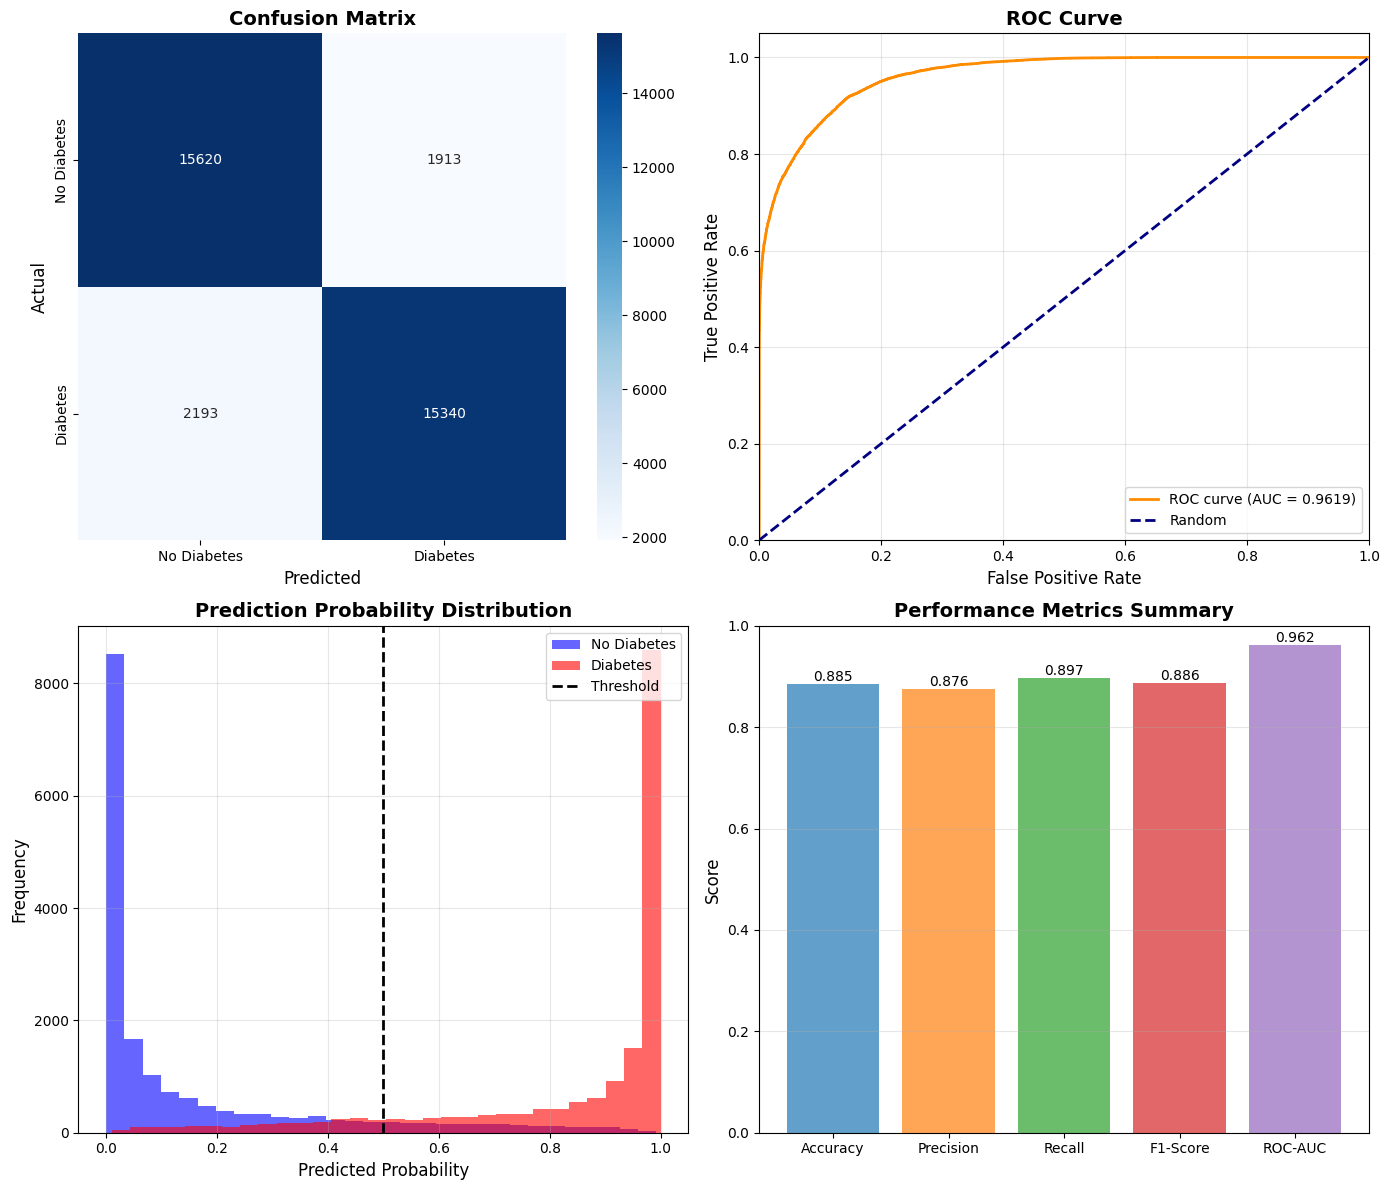

✓ Visualizations generated and saved


<Figure size 640x480 with 0 Axes>

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontsize=12)
axes[0, 0].set_xlabel('Predicted', fontsize=12)

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc_val = auc(fpr, tpr)
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc_val:.4f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

# 3. Prediction Distribution
axes[1, 0].hist(y_pred_proba[y_true == 0], bins=30, alpha=0.6, label='No Diabetes', color='blue')
axes[1, 0].hist(y_pred_proba[y_true == 1], bins=30, alpha=0.6, label='Diabetes', color='red')
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1, 0].set_xlabel('Predicted Probability', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Metrics Bar Chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
metrics_values = [accuracy, precision, recall, f1, roc_auc]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors, alpha=0.7)
axes[1, 1].set_ylim([0, 1])
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('Performance Metrics Summary', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
plt.savefig('tabtransformer_results.png', dpi=300, bbox_inches='tight')


print("✓ Visualizations generated and saved")

In [14]:
save_path = "/content/drive/MyDrive/DiabetesPrediction/models/tabtransformer_model"
tabular_model.save_model(save_path)
print(f"✓ Model saved to: {save_path}")

✓ Model saved to: /content/drive/MyDrive/DiabetesPrediction/models/tabtransformer_model
